# Image Classification

#### Adding all the imports

In [1]:
import os
import random
import shutil
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import zipfile
import requests

#### Loading Dataset from GitHub

In [2]:
repo_url = 'https://github.com/PK0024/Waste/archive/99e7ca9e6aea0f709f1a3fe002d485fb90f84e59.zip'
zip_path = 'waste_data.zip'

#### Downloading the zip file

In [3]:
response = requests.get(repo_url)
with open(zip_path, 'wb') as file:
    file.write(response.content)

#### Extract the zip file

In [4]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('.')

#### Define paths to cardboard and glass folders after extraction

In [5]:
data_folder = 'Waste-99e7ca9e6aea0f709f1a3fe002d485fb90f84e59/Garbage classification/Garbage classification'
cardboard_folder = os.path.join(data_folder, 'cardboard')
glass_folder = os.path.join(data_folder, 'glass')

#### Function to merge images from source folders to destination folder

In [6]:
def merge_images(src_folders, dest_folder):
    os.makedirs(dest_folder, exist_ok=True)
    for folder in src_folders:
        for file_name in os.listdir(folder):
            src_file = os.path.join(folder, file_name)
            dest_file = os.path.join(dest_folder, file_name)
            shutil.copy(src_file, dest_file)

#### Merge cardboard and glass images into a single folder

In [9]:
merged_folder = 'merged_images'
merge_images([cardboard_folder, glass_folder], merged_folder)

#### Define paths for training and testing sets

In [10]:
train_folder = 'train'
test_folder = 'test'

#### Create subdirectories for train and test sets

In [12]:
train_cardboard = os.path.join(train_folder, 'cardboard')
train_glass = os.path.join(train_folder, 'glass')
test_cardboard = os.path.join(test_folder, 'cardboard')
test_glass = os.path.join(test_folder, 'glass')

os.makedirs(train_cardboard, exist_ok=True)
os.makedirs(train_glass, exist_ok=True)
os.makedirs(test_cardboard, exist_ok=True)
os.makedirs(test_glass, exist_ok=True)

#### Function to split data into train and test sets randomly

In [13]:
def split_data_randomly(src_folder, train_dest, test_dest, split_ratio):
    files = os.listdir(src_folder)
    random.shuffle(files)
    split_index = int(len(files) * split_ratio)
    train_files = files[:split_index]
    test_files = files[split_index:]
    for file in train_files:
        shutil.copy(os.path.join(src_folder, file), os.path.join(train_dest, file))
    for file in test_files:
        shutil.copy(os.path.join(src_folder, file), os.path.join(test_dest, file))

#### split merged data into train and test sets

In [14]:
split_data_randomly(cardboard_folder, train_cardboard, test_cardboard, split_ratio=0.8)
split_data_randomly(glass_folder, train_glass, test_glass, split_ratio=0.8)

#### Define image size and batch size

In [15]:
image_size = (224, 224)
batch_size = 32

#### Enhanced Data Augmentation

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 711 images belonging to 2 classes.
Found 179 images belonging to 2 classes.


#### Load pre-trained VGG16 model + higher level layers

In [17]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


#### Freeze base model

In [18]:
for layer in base_model.layers:
    layer.trainable = False

#### Add custom layers on top of VGG16 base

In [19]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


#### Compile the model

In [20]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#### Define callbacks for early stopping and learning rate reduction

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

#### Train the model with callbacks

In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
22/22 [==============================] - 536s 25s/step - loss: 0.7186 - accuracy: 0.5331 - val_loss: 0.6670 - val_accuracy: 0.7063 - lr: 1.0000e-04
Epoch 2/50
22/22 [==============================] - 547s 25s/step - loss: 0.6757 - accuracy: 0.5909 - val_loss: 0.6269 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 3/50
22/22 [==============================] - 550s 25s/step - loss: 0.6563 - accuracy: 0.6293 - val_loss: 0.5920 - val_accuracy: 0.8375 - lr: 1.0000e-04
Epoch 4/50
22/22 [==============================] - 450s 21s/step - loss: 0.6182 - accuracy: 0.6598 - val_loss: 0.5685 - val_accuracy: 0.8438 - lr: 1.0000e-04
Epoch 5/50
22/22 [==============================] - 458s 21s/step - loss: 0.6068 - accuracy: 0.6974 - val_loss: 0.5356 - val_accuracy: 0.8625 - lr: 1.0000e-04
Epoch 6/50
22/22 [==============================] - 504s 23s/step - loss: 0.5704 - accuracy: 0.7378 - val_loss: 0.5032 - val_accuracy: 0.8813 - lr: 1.0000e-04
Epoch 7/50
22/22 [============================

#### Evaluate the model on the test set

In [23]:
steps = test_generator.samples // batch_size
if test_generator.samples % batch_size != 0:
    steps += 1

test_loss, test_accuracy = model.evaluate(test_generator, steps=steps)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

6/6 [==============================] - 95s 16s/step - loss: 0.2280 - accuracy: 0.9497
Test accuracy: 94.97%


#### Plot training & validation accuracy values

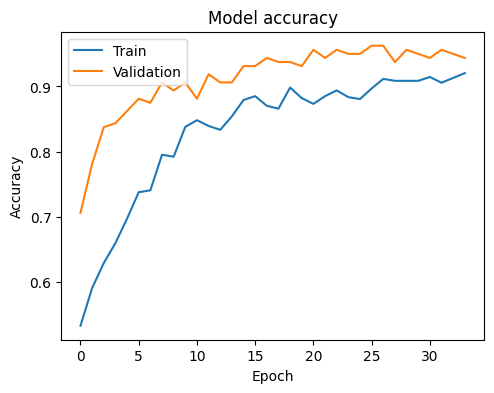

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

#### Plot training & validation loss values

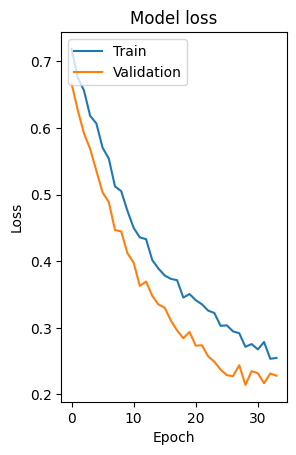

In [25]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Function to count images in each class in a directory

In [26]:
def count_images_in_classes(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

#### Count images in training and testing directories

In [27]:
train_counts = count_images_in_classes(train_folder)
test_counts = count_images_in_classes(test_folder)

print('Training set image counts:', train_counts)
print('Testing set image counts:', test_counts)

Training set image counts: {'cardboard': 322, 'glass': 389}
Testing set image counts: {'cardboard': 81, 'glass': 98}
